In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [36]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)


In [37]:
# Define ConvModule, InceptionModule, and DownsampleModule as per your updated architecture
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class InceptionModule(nn.Module):
    def __init__(self, in_channels, f_1x1, f_3x3):
        super(InceptionModule, self).__init__()
        self.branch1 = ConvModule(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        self.branch2 = ConvModule(in_channels, f_3x3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)

class DownsampleModule(nn.Module):
    def __init__(self, in_channels, f_3x3):
        super(DownsampleModule, self).__init__()
        self.branch1 = ConvModule(in_channels, f_3x3, kernel_size=3, stride=2, padding=0)
        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)

class InceptionSmall(nn.Module):
    def __init__(self, num_classes=10):
        super(InceptionSmall, self).__init__()
        self.conv1 = ConvModule(in_channels=1, out_channels=96, kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96, f_1x1=32, f_3x3=32)
        self.inception2 = InceptionModule(in_channels=64, f_1x1=32, f_3x3=48)
        self.down1 = DownsampleModule(in_channels=80, f_3x3=80)
        self.inception3 = InceptionModule(in_channels=160, f_1x1=112, f_3x3=48)
        self.inception4 = InceptionModule(in_channels=160, f_1x1=96, f_3x3=64)
        self.inception5 = InceptionModule(in_channels=160, f_1x1=80, f_3x3=80)
        self.inception6 = InceptionModule(in_channels=160, f_1x1=48, f_3x3=96)
        self.down2 = DownsampleModule(in_channels=144, f_3x3=96)
        self.inception7 = InceptionModule(in_channels=240, f_1x1=176, f_3x3=160)
        self.inception8 = InceptionModule(in_channels=336, f_1x1=176, f_3x3=160)
        self.meanpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Linear(16464, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.down1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.down2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.meanpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Train the model with increasing batch sizes and fixed learning rate
def train_with_increasing_batch_size(model, trainset, lr_max, batch_sizes, epochs_per_batch_size, device):
    criterion = nn.CrossEntropyLoss()
    train_losses = []

    for batch_size in batch_sizes:
        # Reinitialize DataLoader with the new batch size
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)

        # Reinitialize the model and optimizer
        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr_max)

        running_loss = 0.0

        for epoch in range(epochs_per_batch_size):
            model.train()
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        print(f'Batch Size: {batch_size}, Avg Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)

    return train_losses

In [38]:
lr_max = 1e-2  # Fix learning rate to lrmax from Question 1
batch_sizes = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]  # Batch sizes in powers of 2
epochs_per_batch_size = 5  # Number of epochs to train per batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and train using increasing batch sizes
model = InceptionSmall()
train_losses = train_with_increasing_batch_size(model, trainset, lr_max, batch_sizes, epochs_per_batch_size, device)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Batch Size: 32, Avg Training Loss: 2.1886
Batch Size: 64, Avg Training Loss: 0.9163
Batch Size: 128, Avg Training Loss: 0.4755
Batch Size: 256, Avg Training Loss: 0.1628
Batch Size: 512, Avg Training Loss: 0.0575
Batch Size: 1024, Avg Training Loss: 0.0230
Batch Size: 2048, Avg Training Loss: 0.0071
Batch Size: 4096, Avg Training Loss: 0.0032


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.65 GiB. GPU 0 has a total capacity of 14.75 GiB of which 415.06 MiB is free. Process 8356 has 14.34 GiB memory in use. Of the allocated memory 11.32 GiB is allocated by PyTorch, and 2.89 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [25]:
!nvidia-smi

Fri Sep 27 23:05:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              32W /  70W |    437MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

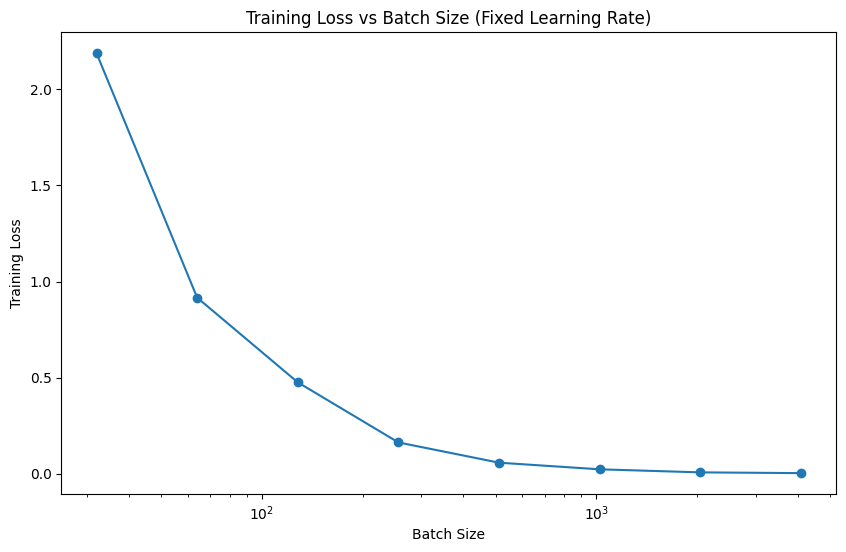

In [42]:
batch_sizes = [32, 64, 128, 256, 512, 1024, 2048, 4096]
training_losses = [2.1886, 0.9163, 0.4755, 0.1628, 0.0575, 0.0230, 0.0071, 0.0032]


plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, training_losses, marker='o')
plt.xscale('log')
plt.xlabel('Batch Size')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Batch Size (Fixed Learning Rate)')
plt.show()